In [70]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer

from transformers import BertTokenizer, TFBertModel

from bert.tokenization.bert_tokenization import FullTokenizer


import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
sw = stopwords.words('english')

# Initial EDA

In [2]:
# Reading in dataset
import pandas as pd
all_data = pd.read_csv("winemag-data-130k-v2.csv")
all_data.shape

(129971, 14)

There are 129,971 wine reviews on our data set.

In [3]:
all_data.head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


In [4]:
# Using just the description and variety of wine
dv_data = all_data[['description', 'variety']]
dv_data.head()

,description,variety
0,"Aromas include tropical fruit, broom, brimston...",White Blend
1,"This is ripe and fruity, a wine that is smooth...",Portuguese Red
2,"Tart and snappy, the flavors of lime flesh and...",Pinot Gris
3,"Pineapple rind, lemon pith and orange blossom ...",Riesling
4,"Much like the regular bottling from 2012, this...",Pinot Noir


In [5]:
# Top 10 most reviewed varieties
variety_count = dv_data.variety.value_counts()
variety_count.head(10), len(variety_count)

(Pinot Noir                  13272
 Chardonnay                  11753
 Cabernet Sauvignon           9472
 Red Blend                    8946
 Bordeaux-style Red Blend     6915
 Riesling                     5189
 Sauvignon Blanc              4967
 Syrah                        4142
 Rosé                         3564
 Merlot                       3102
 Name: variety, dtype: int64,
 707)

There are 707 different varieties of wine in our data set.

In [6]:
classes = variety_count.index[:10].tolist()
classes

['Pinot Noir',
 'Chardonnay',
 'Cabernet Sauvignon',
 'Red Blend',
 'Bordeaux-style Red Blend',
 'Riesling',
 'Sauvignon Blanc',
 'Syrah',
 'Rosé',
 'Merlot']

In [7]:
# Selecting wine reviews for top 10 varieties only
variety_mask = dv_data['variety'].isin(classes)
data = dv_data[variety_mask]
data.head()

,description,variety
3,"Pineapple rind, lemon pith and orange blossom ...",Riesling
4,"Much like the regular bottling from 2012, this...",Pinot Noir
10,"Soft, supple plum envelopes an oaky structure ...",Cabernet Sauvignon
12,"Slightly reduced, this wine offers a chalky, t...",Cabernet Sauvignon
14,Building on 150 years and six generations of w...,Chardonnay


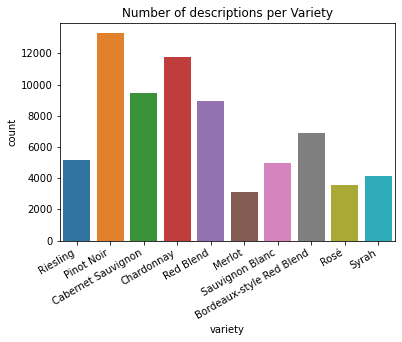

In [8]:
chart = sns.countplot(data.variety)
plt.title("Number of descriptions per Variety")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [9]:
# Merlot is the variety of wine with the least amount of reviews in our dataset
print("Number of Merlot reviews:", sum(data['variety'] == "Merlot"))

Number of Merlot reviews: 3102


In [10]:
# Sampling reviews of the top 10 varieties to create a uniform dataset
df = data[data['variety'] == 'Merlot']
for i in variety_count.index[:9]:
    df = df.append(data[data['variety'] == i].sample(n=sum(data['variety'] == "Merlot"), random_state = 32))

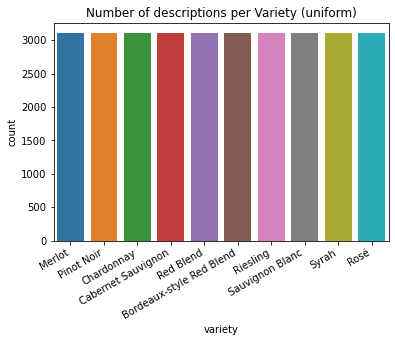

In [11]:
chart = sns.countplot(df.variety)
plt.title("Number of descriptions per Variety (uniform)")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Data Preprocessing


In [12]:
# Integer encode variety labels
label_encoder = LabelEncoder()
variety_encoded = label_encoder.fit_transform(df.variety)

In [14]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(df.description, variety_encoded, test_size = 0.25, random_state = 88)

In [15]:
train_df = pd.DataFrame({'text': X_train, 'labels': y_train})
test_df = pd.DataFrame({'text': X_test, 'labels': y_test})

In [16]:
train_df.head(2)

,text,labels
30035,"This wine is full in the mouth, with swathes o...",2
71761,Blended with smaller amounts of Merlot and Pet...,1


#### Tokenizing text

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [19]:
def tokenize_text(text):
    ids = []
    sentence_len = []
    for i in range(len(text.values)):
      token_ids = tokenizer.encode(text.values[i])
      ids.append(token_ids)
      sentence_len.append(len(token_ids))
    return ids, sentence_len

In [20]:
train_df['token_ids'], train_df['sentence_len'] = tokenize_text(train_df.text)
test_df['token_ids'], test_df['sentence_len'] = tokenize_text(test_df.text)


#### Padding text

In [21]:
def pad_text(df):
    x = []
    max_length = max(train_df.sentence_len.values)

    for input_ids in df.token_ids.values:
      input_ids = input_ids[:min(len(input_ids), max_length - 2)]
      input_ids = input_ids + [0] * (max_length - len(input_ids))
      x.append(np.array(input_ids))
    
    return x

In [22]:
train_df['padded_ids'] = pad_text(train_df)
test_df['padded_ids'] = pad_text(test_df)

In [23]:
len(train_df.padded_ids.iloc[0])

194

#### Masked Inputs

In [24]:
def mask_padded_input(df):
    x = []

    for padded_ids in df.padded_ids.values:
      masked = np.where(padded_ids != 0, 1, 0)
      x.append(np.array(masked))
    
    return x

In [25]:
train_df['masked'] = mask_padded_input(train_df)
test_df['masked'] = mask_padded_input(test_df)

In [26]:
train_df.head()

,text,labels,token_ids,sentence_len,padded_ids,masked
30035,"This wine is full in the mouth, with swathes o...",2,"[101, 2023, 4511, 2003, 2440, 1999, 1996, 2677...",45,"[101, 2023, 4511, 2003, 2440, 1999, 1996, 2677...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
71761,Blended with smaller amounts of Merlot and Pet...,1,"[101, 19803, 2007, 3760, 8310, 1997, 21442, 10...",50,"[101, 19803, 2007, 3760, 8310, 1997, 21442, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
110222,"A good Pinot Noir, dry and elegantly structure...",4,"[101, 1037, 2204, 9231, 4140, 15587, 1010, 431...",55,"[101, 1037, 2204, 9231, 4140, 15587, 1010, 431...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
61596,This structured wine opens with aromas of subt...,5,"[101, 2023, 14336, 4511, 7480, 2007, 23958, 20...",54,"[101, 2023, 14336, 4511, 7480, 2007, 23958, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
79733,Bees wax and smoke meld with unctuously sweet ...,6,"[101, 13734, 13844, 1998, 5610, 11463, 2094, 2...",64,"[101, 13734, 13844, 1998, 5610, 11463, 2094, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [27]:
train_inputs = np.array([train_df.padded_ids.tolist(), train_df.masked.tolist()])
train_inputs.shape

(2, 23265, 194)

In [28]:
test_inputs = np.array([test_df.padded_ids.tolist(), test_df.masked.tolist()])
test_inputs.shape

(2, 7755, 194)

In [29]:
train_all = [train_inputs, y_train]
test_all = [test_inputs, y_test]

In [30]:
train_inputs[0].shape

(23265, 194)

# Initial Model Build

In [ ]:
tf.keras.backend.clear_session()

In [31]:
def bert_model(max_length, train_layers):
    """
    variables:
        max_input_length: number of tokens (max_length + 1)
        train_layers: number of layers to be retrained
        optimizer: optimizer to be used
    
    returns: model
    """
    
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="input_ids")
    
    bert_layer = TFBertModel.from_pretrained('bert-base-uncased')
    
    # Freeze layers
    
    if not train_layers == -1:
        
        retrain_layers = []
    
        for retrain_layer_number in range(train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)

        for w in bert_layer.weights:
            if not any([x in w.name for x in retrain_layers]):
                w._trainable = False

        # End of freezing section
    
    bert_sequence = bert_layer(input_ids)[0]
    
    print('Let us check the shape of the BERT layer output:', bert_sequence)
    
    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_sequence)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=10, activation="softmax")(logits)
     
    print('pred: ', logits)
    
    ## Prepare for multipe loss functions, although not used here
    
    model = tf.keras.models.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_length))

    model.compile(
        optimizer = keras.optimizers.Adam(1e-5), 
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics = [keras.metrics.SparseCategoricalAccuracy(name="acc")]
    )
    
    model.build(input_shape=(None, max_length))

    return model

In [32]:
bert_model = bert_model(max_length = max(train_df.sentence_len.values), train_layers = -1)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Let us check the shape of the BERT layer output: KerasTensor(type_spec=TensorSpec(shape=(None, 194, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'tf_bert_mo

In [33]:
bert_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 194)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_38 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7690  

In [34]:
train_input = np.matrix(train_df.padded_ids.tolist())
test_input = np.matrix(test_df.padded_ids.tolist())

In [35]:
history = bert_model.fit(
    train_input, 
    y_train,
    validation_data=(test_input, y_test),
    epochs=5,
    batch_size=32
)

Epoch 1/5
728/728 [==============================] - 13402s 18s/step - loss: 2.2342 - acc: 0.2079 - val_loss: 0.8984 - val_acc: 0.6865
Epoch 2/5
728/728 [==============================] - 14781s 20s/step - loss: 0.9288 - acc: 0.6741 - val_loss: 0.7474 - val_acc: 0.7389
Epoch 3/5
728/728 [==============================] - 15590s 21s/step - loss: 0.7373 - acc: 0.7442 - val_loss: 0.6876 - val_acc: 0.7642
Epoch 4/5
728/728 [==============================] - 11328s 16s/step - loss: 0.6354 - acc: 0.7806 - val_loss: 0.6706 - val_acc: 0.7714
Epoch 5/5
728/728 [==============================] - 10313s 14s/step - loss: 0.5512 - acc: 0.8060 - val_loss: 0.6611 - val_acc: 0.7812


# Results

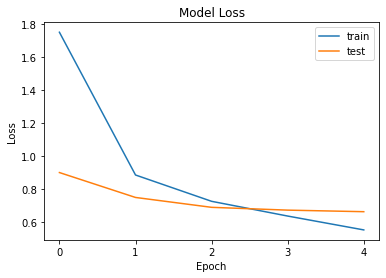

In [43]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Model Loss')
plt.show();

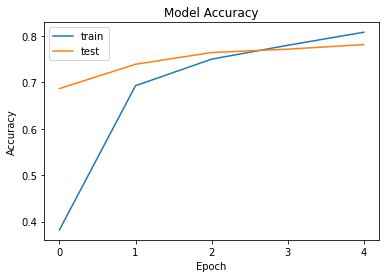

In [44]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Model Accuracy')
plt.show();

In [38]:
y_pred = bert_model.predict(test_input).argmax(axis=-1)

In [45]:
classes = label_encoder.classes_

In [46]:
print(classification_report(y_test, y_pred, target_names=classes))

                          precision    recall  f1-score   support

Bordeaux-style Red Blend       0.78      0.87      0.82       786
      Cabernet Sauvignon       0.69      0.65      0.67       778
              Chardonnay       0.78      0.89      0.83       793
                  Merlot       0.65      0.63      0.64       771
              Pinot Noir       0.73      0.73      0.73       747
               Red Blend       0.81      0.73      0.77       778
                Riesling       0.94      0.88      0.91       772
                    Rosé       0.81      0.93      0.87       780
         Sauvignon Blanc       0.85      0.80      0.82       778
                   Syrah       0.78      0.69      0.73       772

                accuracy                           0.78      7755
               macro avg       0.78      0.78      0.78      7755
            weighted avg       0.78      0.78      0.78      7755



In [47]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

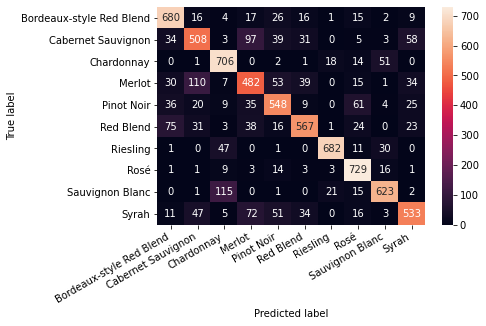

In [48]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# Error Analysis

In [63]:
def get_wrong_pred(true_label, pred_label):
    wrong_pred = []
    t_label = label_encoder.classes_.tolist().index(true_label)
    p_label = label_encoder.classes_.tolist().index(pred_label)
    
    for i in range(len(test_df.text)):
        if y_test[i] == t_label and y_pred[i] == p_label:
            wrong_text = test_df.text.iloc[i]
            wrong_pred.append(wrong_text)
 
    print("True Label:", true_label, ", and Predictied Label:", pred_label )
    print('Number of reviews misclassified:', len(wrong_pred))
    
    return wrong_pred

#### Cabernet Sauvignon and Merlot

In [64]:
cab_sauv_versus_merlot = get_wrong_pred("Cabernet Sauvignon", "Merlot")

True Label: Cabernet Sauvignon , and Predictied Label: Merlot
Number of reviews misclassified: 97


In [65]:
# Print descriptions of misclassified reviews
for i in cab_sauv_versus_merlot[:5]:
    print("-"*60)
    print(i)

------------------------------------------------------------
A healthy 20% of Merlot provides additional softness in this food-friendly, well-integrated wine, bright in crisp cranberry and mellowed oak and tannin. Well-made at a fair price, it's well worth the seek.
------------------------------------------------------------
Highlighted in Rainier cherry and cassis fruit, with a core of high acidity, this is a drinkable, affordable red wine worth looking for.
------------------------------------------------------------
This wine has aromas of coffee, toast, cherry meats, herbs, mocha and barrel spices along with a lightly green edge. It's tart and flavorful, with a supple feel and chalky tannins.
------------------------------------------------------------
Aromas of tire rubber, plum and spice are followed sweet currant and cranberry flavors. The tannins bring some grit.
------------------------------------------------------------
There's much to like in this wine's notes of cocoa and

#### Sauvignon Blanc and Chardonnay

In [67]:
sauv_blanc_versus_chard = get_wrong_pred("Sauvignon Blanc", "Chardonnay")

True Label: Sauvignon Blanc , and Predictied Label: Chardonnay
Number of reviews misclassified: 115


In [68]:
# Print descriptions of misclassified reviews
for i in sauv_blanc_versus_chard[:5]:
    print("-"*60)
    print(i)

------------------------------------------------------------
Waxy apple opens the nose before this tame stainless-steel aged white builds flavors of pear and vanilla extract amid a medium-bodied frame. More pear, with a wrapping of gingery spice, is featured on the finish.
------------------------------------------------------------
From the border of the Emilia-Romagna and Lombardy regions of Northern Italy, this organic white wine shows warm aromas of peach, apricot, caramel and melon backed by touches of toasted almond and yellow rose. The mouthfeel is chewy and thick.
------------------------------------------------------------
This big-bodied wine is full of smoke, toast and custard in the nose, sure signs of barrel fermentation or aging. The mouth is packed with thick, custardy citrus fruit, which renders it a bit like orange-tinged flan. Fortunately, it retains its acids, which keeps it well balanced despite the heavy oaking it went through.
-------------------------------------

### Wine Variety Vocabulary

In [71]:
from string import punctuation


def get_top_counts(X, vec):
    counts = np.array(np.sum(X, axis=0))[0]
    vocab_inv = {k: counts[v] for k, v in vec.vocabulary_.items()}
    return vocab_inv

def get_most_common(counts_dict, n=None):
    words = np.array(list(counts_dict.keys()))
    counts = np.array(list(counts_dict.values()))
    
    counts_sorted_idx = np.argsort(counts)[::-1]
    if n:
        counts_sorted_idx = counts_sorted_idx[:n]
        
    return words[counts_sorted_idx], counts[counts_sorted_idx]
normal_stopwords = nltk.corpus.stopwords.words('english')
top_domain_specific_words = []
n = 10

vec = CountVectorizer(
    lowercase=True,
    stop_words=normal_stopwords,
    ngram_range=(1, 1,),
    min_df=10
)
X =  vec.fit_transform(data['description'])

temp_counts = get_top_counts(X, vec)
most_common_words, most_common_counts = get_most_common(temp_counts, n=n)
        
stop_words = list(most_common_words) + normal_stopwords + list(punctuation)
stop_words = set(stop_words)

In [72]:
def get_vec(data, **kwargs):
    vec = CountVectorizer(
        lowercase=True,
        stop_words=stop_words,
        **kwargs
    )
    return vec.fit_transform(data), vec
        
def print_top_counts(X, vec, title='Top Counts', n=10):
    vocab_counts = get_top_counts(X, vec)
    
    vocab, counts = get_most_common(vocab_counts, n=n)
    print(title)
    for v, c in zip(vocab, counts):
        print(f'\t{v}: {c}')

In [73]:
varieties = variety_count.index[:10]
variety_vocabs = {}
for i in varieties:
    variety_descriptions = data[data['variety'] == i]['description']
    variety_vocabs[i] = get_vec(variety_descriptions, ngram_range=(1,1))

In [74]:
red_variety = ['Merlot', 'Cabernet Sauvignon']
n = 10
for name in red_variety:
    variety_X, vec = variety_vocabs[name]
    print_top_counts(variety_X, vec, title=f'{name} counts:', n=n)

Merlot counts:
	merlot: 1287
	red: 772
	plum: 688
	oak: 646
	soft: 542
	spice: 493
	berry: 484
	ripe: 480
	dry: 478
	notes: 464
Cabernet Sauvignon counts:
	cabernet: 3170
	oak: 2624
	blackberry: 2430
	cassis: 1710
	drink: 1585
	chocolate: 1564
	ripe: 1526
	red: 1480
	plum: 1467
	currant: 1454


In [75]:
white_variety = ['Sauvignon Blanc', 'Chardonnay']
n = 10
for name in white_variety:
    variety_X, vec = variety_vocabs[name]
    print_top_counts(variety_X, vec, title=f'{name} counts:', n=n)

Sauvignon Blanc counts:
	green: 1483
	citrus: 1443
	sauvignon: 1314
	blanc: 1189
	crisp: 1129
	drink: 1046
	lime: 1034
	grapefruit: 987
	fresh: 930
	ripe: 898
Chardonnay counts:
	apple: 3926
	chardonnay: 3315
	oak: 2877
	ripe: 2811
	drink: 2459
	lemon: 2298
	pear: 2193
	crisp: 2112
	rich: 2110
	vanilla: 1992
